In [30]:
# set up pathway for DeepPurpose module and import necessary libraries and dependencies
import os
os.chdir('./')# specify location of directory containing DeepPurpose module
from DeepPurpose import utils, CompoundPred
from tdc.single_pred import ADME
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [31]:
# This function uses either a MPNN,Rf or Transformer on four datasets the user can choose the combination of data and ml algorithm as they wish
def rf_mpnn_trans(drug_encoding = 'MPNN',name = 'Pgp_Broccatelli'):
    
    def remove_low_variance(input_data, threshold=0.1):
        selection = VarianceThreshold(threshold)
        selection.fit(input_data)
        return input_data[input_data.columns[selection.get_support(indices=True)]]
    
    # For DL algos method from DeepPurpose Library to obtain data in desired format ready for modelling 
    X, y = ADME(name = name).get_data(format = 'DeepPurpose')
    
    if drug_encoding == 'MPNN':
        train, val, test = utils.data_process(X_drug = X, 
                                              y = y, 
                                              drug_encoding = drug_encoding,
                                              random_seed = 'TDC'
                                             )

        config = utils.generate_config(drug_encoding = drug_encoding, 
                                       train_epoch = 10, 
                                       LR = 0.001, 
                                       batch_size = 256,
                                       mpnn_hidden_size = 50,
                                       mpnn_depth = 3
                                      )

        model = CompoundPred.model_initialize(**config)

        # Training
        model.train(train, val, test)
    
    elif drug_encoding == 'Transformer':
        train, val, test = utils.data_process(X_drug = X, 
                                              y = y, 
                                              drug_encoding = drug_encoding,
                                              random_seed = 'TDC'
                                             )

        config = utils.generate_config(drug_encoding = drug_encoding, 
                                       train_epoch = 10, 
                                       LR = 0.001, 
                                       batch_size = 256,
                                       mpnn_hidden_size = 50,
                                       mpnn_depth = 3
                                      )

        model = CompoundPred.model_initialize(**config)

        # Training
        model.train(train, val, test)
    
    elif drug_encoding == 'rf':
        if name == 'Pgp_Broccatelli':
            df_pgp_desc = pd.read_csv('pgp_descriptors.csv',sep='\t')
            df_pgp = pd.read_csv('pgp.csv')
            X = df_pgp_desc.drop(['Unnamed: 0','Name'],axis=1)
            y = df_pgp['pgp_inhib']
            X = remove_low_variance(X, threshold=0.1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=500, random_state=42)
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            r_probs = [0 for _ in range(len(y_test))]
            rf_probs = model.predict_proba(X_test)
            rf_probs = rf_probs[:, 1]
            r_auc = roc_auc_score(y_test, r_probs)
            rf_auc = roc_auc_score(y_test, rf_probs)
            print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
            print('Random Forest: AUROC = %.3f' % (rf_auc))
            r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
            rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
            plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
            plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)

            # Title
            plt.title('ROC Plot')
            # Axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # Show legend
            plt.legend()  
            # Show plot
            plt.show()
        
        elif name == 'CYP1A2_Veith':
            df_cyp1a2_desc = pd.read_csv('cyp_1a2_descriptors.csv',sep='\t')
            df_cyp1a2 = pd.read_csv('cyp_1a2.csv')
            X = df_cyp1a2_desc.drop(['Unnamed: 0','Name'],axis=1)
            y = df_cyp1a2['cyp_1a2']
            X = remove_low_variance(X, threshold=0.1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=500, random_state=42)
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            r_probs = [0 for _ in range(len(y_test))]
            rf_probs = model.predict_proba(X_test)
            rf_probs = rf_probs[:, 1]
            r_auc = roc_auc_score(y_test, r_probs)
            rf_auc = roc_auc_score(y_test, rf_probs)
            print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
            print('Random Forest: AUROC = %.3f' % (rf_auc))
            r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
            rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
            plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
            plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)

            # Title
            plt.title('ROC Plot')
            # Axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # Show legend
            plt.legend()  
            # Show plot
            plt.show()
            
        elif name == 'BBB_Martins':
            df_bbb_martins_desc = pd.read_csv('BBB_Martins_descriptors.csv',sep='\t')
            df_bbb_martins = pd.read_csv('BBB_Martins.csv')
            X = df_bbb_martins_desc.drop(['Unnamed: 0','Name'],axis=1)
            y = df_bbb_martins['BBB_Martins']
            X = remove_low_variance(X, threshold=0.1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=500, random_state=42)
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            r_probs = [0 for _ in range(len(y_test))]
            rf_probs = model.predict_proba(X_test)
            rf_probs = rf_probs[:, 1]
            r_auc = roc_auc_score(y_test, r_probs)
            rf_auc = roc_auc_score(y_test, rf_probs)
            print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
            print('Random Forest: AUROC = %.3f' % (rf_auc))
            r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
            rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
            plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
            plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)

            # Title
            plt.title('ROC Plot')
            # Axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # Show legend
            plt.legend()  
            # Show plot
            plt.show()
            
        elif name == 'Clearance_Hepatocyte_AZ':
            df_Clearance_Hepatocyte_AZ_desc = pd.read_csv('Clearance_Hepatocyte_AZ_descriptors.csv',sep='\t')
            df_Clearance_Hepatocyte_AZ = pd.read_csv('Clearance_Hepatocyte_AZ.csv')
            X = df_Clearance_Hepatocyte_AZ_desc.drop(['Unnamed: 0','Name'],axis=1)
            y = df_Clearance_Hepatocyte_AZ['Clearance_Hepatocyte_AZ']
            X = remove_low_variance(X, threshold=0.1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestRegressor(n_estimators=500, random_state=42)
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))

### MPNN on Pgp data (Absorption)

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 1218 drugs
encoding drug...
unique drugs: 1212
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69180. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.50027 , AUPRC: 0.62165 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.69807. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.52472 , AUPRC: 0.57809 , F1: 0.74226
Training at Epoch 3 iteration 0 with loss 0.69070. Total time 0.00027 hours
Validation at Epoch 3 , AUROC: 0.40083 , AUPRC: 0.53665 , F1: 0.74226
Training at Epoch 4 iteration 0 with loss 0.69045. Total time 0.00055 hours
Validation at Epoch 4 , AUROC: 0.50388 , AUPRC: 0.60579 , F1: 0.74226
Training at Epoch 5 iteration 0 with loss 0.68749. Total time 0.00055 hours
Validation at Epoch 5 , AUROC: 0.46888 , AUPRC: 0.57264 , F1: 0.74226
Training at Epoch 6 iteration 0 with loss 0.68678. Total time 0.00083 hours
Validation at Epoch 6 , AUROC: 0.51111 ,

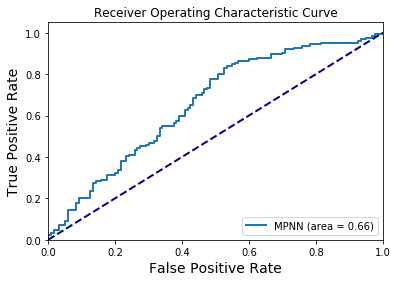

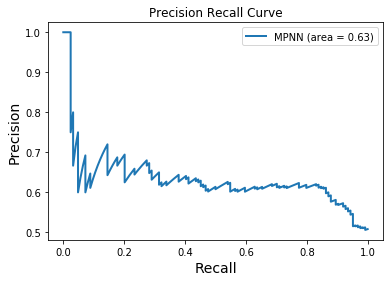

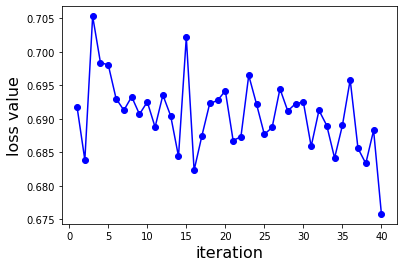

In [8]:
rf_mpnn_trans(drug_encoding='MPNN',name='Pgp_Broccatelli')

### Transformer on Pgp data (Absorption)

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 1218 drugs
encoding drug...
unique drugs: 1212
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69444. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.50027 , AUPRC: 0.55297 , F1: 0.74226
Training at Epoch 2 iteration 0 with loss 0.70478. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.69277 , AUPRC: 0.76395 , F1: 0.74226
Training at Epoch 3 iteration 0 with loss 0.70761. Total time 0.00027 hours
Validation at Epoch 3 , AUROC: 0.71402 , AUPRC: 0.75300 , F1: 0.74226
Training at Epoch 4 iteration 0 with loss 0.69512. Total time 0.00055 hours
Validation at Epoch 4 , AUROC: 0.71944 , AUPRC: 0.75342 , F1: 0.74226
Training at Epoch 5 iteration 0 with loss 0.69582. Total time 0.00083 hours
Validation at Epoch 5 , AUROC: 0.7425 , AUPRC: 0.77546 , F1: 0.74226
Training at Epoch 6 iteration 0 with loss 0.69366. Total time 0.00111 hours
Validation at Epoch 6 , AUROC: 0.7577

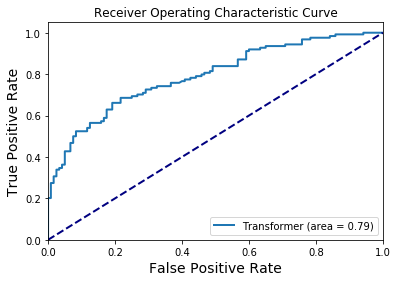

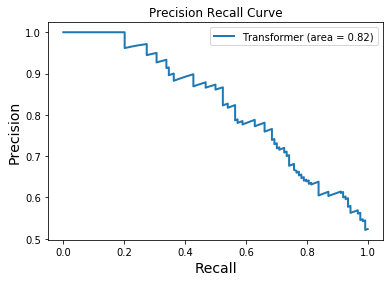

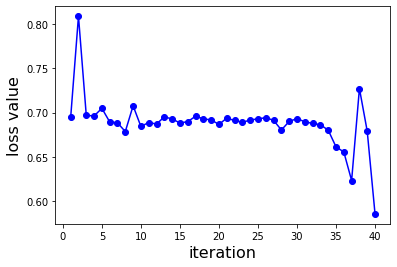

In [10]:
rf_mpnn_trans(drug_encoding='Transformer',name='Pgp_Broccatelli')

### Rf on Pgp data (Absorption)

Found local copy...
Loading...
Done!


Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.817


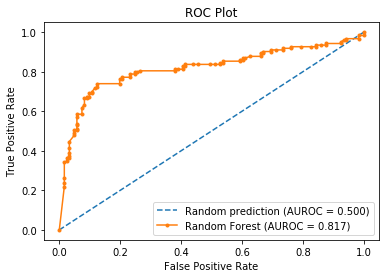

In [11]:
rf_mpnn_trans(drug_encoding='rf',name='Pgp_Broccatelli')

### MPNN on BBB data (Distribution)

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 2030 drugs
encoding drug...
unique drugs: 1975


[23:27:20] WARNING: not removing hydrogen atom without neighbors
[23:27:20] WARNING: not removing hydrogen atom without neighbors
[23:27:20] WARNING: not removing hydrogen atom without neighbors
[23:27:20] WARNING: not removing hydrogen atom without neighbors
[23:27:20] WARNING: not removing hydrogen atom without neighbors
[23:27:20] WARNING: not removing hydrogen atom without neighbors
[23:27:20] WARNING: not removing hydrogen atom without neighbors
[23:27:21] WARNING: not removing hydrogen atom without neighbors
[23:27:21] WARNING: not removing hydrogen atom without neighbors
[23:27:21] WARNING: not removing hydrogen atom without neighbors
[23:27:21] WARNING: not removing hydrogen atom without neighbors
[23:27:22] WARNING: not removing hydrogen atom without neighbors
[23:27:22] WARNING: not removing hydrogen atom without neighbors
[23:27:22] WARNING: not removing hydrogen atom without neighbors
[23:27:23] WARNING: not removing hydrogen atom without neighbors
[23:27:23] WARNING: not r

Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68878. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.53010 , AUPRC: 0.78624 , F1: 0.86592
Training at Epoch 2 iteration 0 with loss 0.55859. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.49811 , AUPRC: 0.75949 , F1: 0.86592
Training at Epoch 3 iteration 0 with loss 0.52437. Total time 0.00055 hours
Validation at Epoch 3 , AUROC: 0.54220 , AUPRC: 0.79971 , F1: 0.86592
Training at Epoch 4 iteration 0 with loss 0.55560. Total time 0.00083 hours
Validation at Epoch 4 , AUROC: 0.50618 , AUPRC: 0.79006 , F1: 0.86592
Training at Epoch 5 iteration 0 with loss 0.46936. Total time 0.00111 hours
Validation at Epoch 5 , AUROC: 0.60282 , AUPRC: 0.81482 , F1: 0.86592
Training at Epoch 6 iteration 0 with loss 0.57037. Total time 0.00138 hours
Validation at Epoch 6 , AUROC: 0.60120 , AUPRC: 0.81059 , F1: 0.86592
Training at Epoch 7 iteration 0 with loss 0.53593. Total

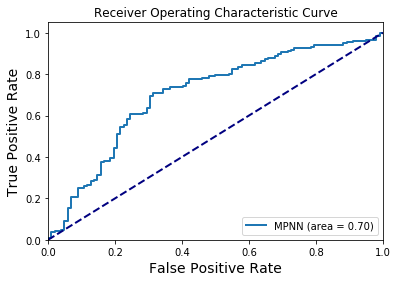

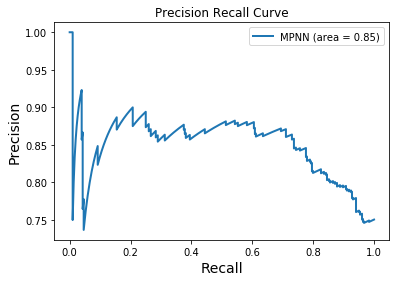

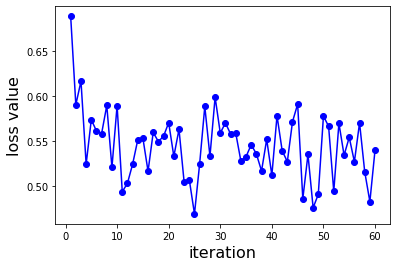

In [12]:
rf_mpnn_trans(drug_encoding='MPNN',name='BBB_Martins')

### Transformer on BBB data (Distribution)

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 2030 drugs
encoding drug...
unique drugs: 1975
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69790. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.65793 , AUPRC: 0.86051 , F1: 0.86592
Training at Epoch 2 iteration 0 with loss 0.56278. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.75235 , AUPRC: 0.89241 , F1: 0.86592
Training at Epoch 3 iteration 0 with loss 0.56590. Total time 0.00055 hours
Validation at Epoch 3 , AUROC: 0.78004 , AUPRC: 0.90130 , F1: 0.86592
Training at Epoch 4 iteration 0 with loss 0.55598. Total time 0.00083 hours
Validation at Epoch 4 , AUROC: 0.75873 , AUPRC: 0.89227 , F1: 0.86592
Training at Epoch 5 iteration 0 with loss 0.62121. Total time 0.00138 hours
Validation at Epoch 5 , AUROC: 0.76888 , AUPRC: 0.89579 , F1: 0.86592
Training at Epoch 6 iteration 0 with loss 0.52705. Total time 0.00166 hours
Validation at Epoch 6 , AUROC: 0.790

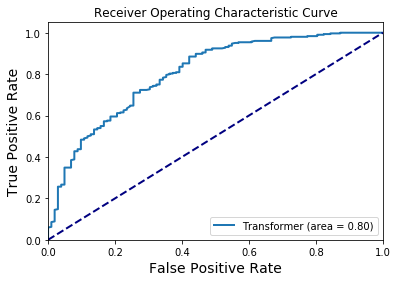

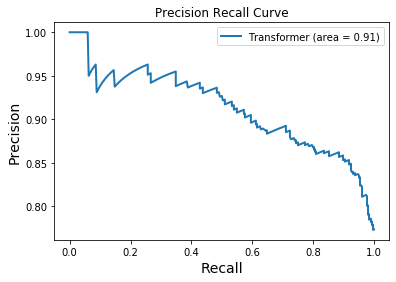

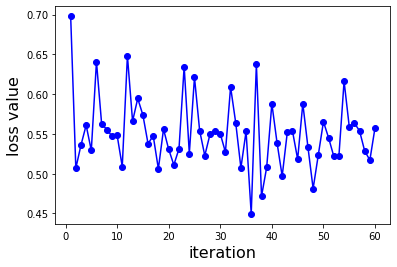

In [15]:
rf_mpnn_trans(drug_encoding='Transformer',name='BBB_Martins')

### Rf on BBB data (Distribution)

Found local copy...
Loading...
Done!


Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.843


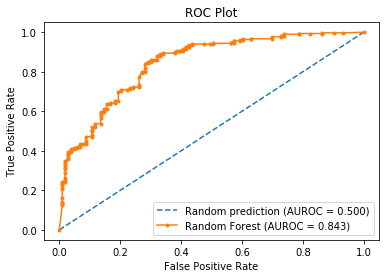

In [16]:
rf_mpnn_trans(drug_encoding='rf',name='BBB_Martins')

### MPNN on cyp1a2 data (Metabolism)

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 12579 drugs
encoding drug...
unique drugs: 12579
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69424. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.65990 , AUPRC: 0.59836 , F1: 0.12576
Training at Epoch 2 iteration 0 with loss 0.70308. Total time 0.00166 hours
Validation at Epoch 2 , AUROC: 0.83331 , AUPRC: 0.79929 , F1: 0.71922
Training at Epoch 3 iteration 0 with loss 0.52093. Total time 0.00305 hours
Validation at Epoch 3 , AUROC: 0.83840 , AUPRC: 0.80514 , F1: 0.74555
Training at Epoch 4 iteration 0 with loss 0.52949. Total time 0.00472 hours
Validation at Epoch 4 , AUROC: 0.84900 , AUPRC: 0.81878 , F1: 0.76034
Training at Epoch 5 iteration 0 with loss 0.49616. Total time 0.00611 hours
Validation at Epoch 5 , AUROC: 0.85296 , AUPRC: 0.82353 , F1: 0.75481
Training at Epoch 6 iteration 0 with loss 0.48797. Total time 0.00777 hours
Validation at Epoch 6 , AUROC: 0.8

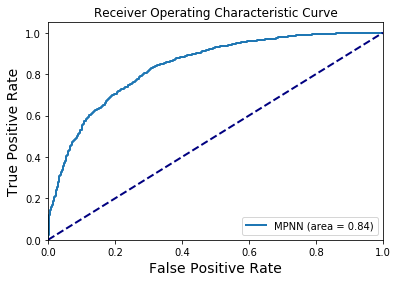

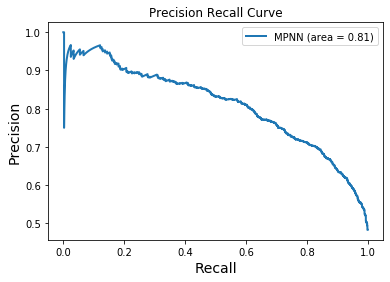

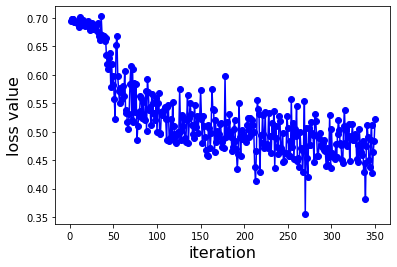

In [17]:
rf_mpnn_trans(drug_encoding='MPNN',name='CYP1A2_Veith')

### Transformer on cyp1a2 data (Metabolism)

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 12579 drugs
encoding drug...
unique drugs: 12579
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69342. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.57899 , AUPRC: 0.52558 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.69699. Total time 0.00194 hours
Validation at Epoch 2 , AUROC: 0.62527 , AUPRC: 0.56876 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.68842. Total time 0.00388 hours
Validation at Epoch 3 , AUROC: 0.49678 , AUPRC: 0.44186 , F1: 0.0
Training at Epoch 4 iteration 0 with loss 0.69098. Total time 0.00583 hours
Validation at Epoch 4 , AUROC: 0.64252 , AUPRC: 0.58335 , F1: 0.0
Training at Epoch 5 iteration 0 with loss 0.68623. Total time 0.00777 hours
Validation at Epoch 5 , AUROC: 0.65065 , AUPRC: 0.59393 , F1: 0.0
Training at Epoch 6 iteration 0 with loss 0.69156. Total time 0.00972 hours
Validation at Epoch 6 , AUROC: 0.66187 , AUPRC: 0.6169

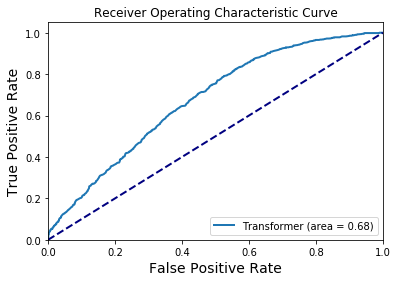

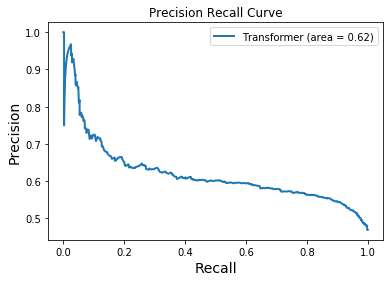

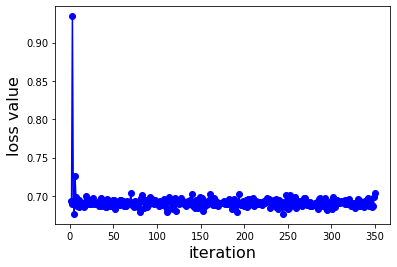

In [18]:
rf_mpnn_trans(drug_encoding='Transformer',name='CYP1A2_Veith')

### Rf on cyp1a2 data (Metabolism)

Found local copy...
Loading...
Done!


Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.663


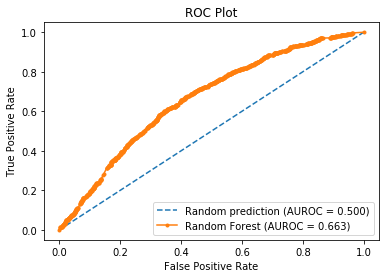

In [19]:
rf_mpnn_trans(drug_encoding='rf',name='CYP1A2_Veith')

### MPNN on clearance AZ data (Excretion)

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 1213 drugs
encoding drug...
unique drugs: 1020
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 4656.77. Total time 0.0 hours
Validation at Epoch 1 , MSE: 2684.24 , Pearson Correlation: 0.01709 with p-value: 8.52E-01 , Concordance Index: 0.48526
Training at Epoch 2 iteration 0 with loss 3236.78. Total time 0.0 hours
Validation at Epoch 2 , MSE: 2413.39 , Pearson Correlation: 0.01172 with p-value: 8.98E-01 , Concordance Index: 0.50058
Training at Epoch 3 iteration 0 with loss 2621.50. Total time 0.00027 hours
Validation at Epoch 3 , MSE: 2306.08 , Pearson Correlation: 0.10922 with p-value: 2.33E-01 , Concordance Index: 0.51677
Training at Epoch 4 iteration 0 with loss 2917.16. Total time 0.00027 hours
Validation at Epoch 4 , MSE: 2348.32 , Pearson Correlation: 0.04405 with p-value: 6.31E-01 , Concordance Index: 0.53996
Training at Epoch 5 iteration 0 with loss 2549.71. Total time 

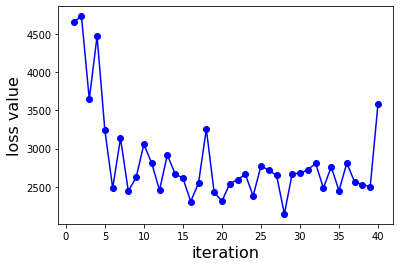

In [23]:
rf_mpnn_trans(drug_encoding='MPNN',name='Clearance_Hepatocyte_AZ')

### Transformer on clearance AZ data (Excretion)

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 1213 drugs
encoding drug...
unique drugs: 1020
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 4655.26. Total time 0.0 hours
Validation at Epoch 1 , MSE: 2498.81 , Pearson Correlation: -0.2020 with p-value: 2.62E-02 , Concordance Index: 0.46368
Training at Epoch 2 iteration 0 with loss 3083.00. Total time 0.00027 hours
Validation at Epoch 2 , MSE: 2372.92 , Pearson Correlation: -0.1630 with p-value: 7.39E-02 , Concordance Index: 0.45624
Training at Epoch 3 iteration 0 with loss 2738.59. Total time 0.00027 hours
Validation at Epoch 3 , MSE: 2370.73 , Pearson Correlation: -0.0352 with p-value: 7.01E-01 , Concordance Index: 0.52093
Training at Epoch 4 iteration 0 with loss 2632.45. Total time 0.00055 hours
Validation at Epoch 4 , MSE: 2368.80 , Pearson Correlation: -0.0052 with p-value: 9.54E-01 , Concordance Index: 0.52195
Training at Epoch 5 iteration 0 with loss 2569.48. Total t

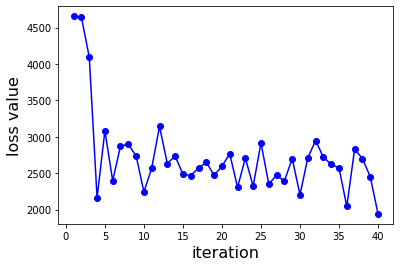

In [24]:
rf_mpnn_trans(drug_encoding='Transformer',name='Clearance_Hepatocyte_AZ')

### Rf on clearance AZ data (Excretion)

In [32]:
rf_mpnn_trans(drug_encoding='rf',name='Clearance_Hepatocyte_AZ')

Found local copy...
Loading...
Done!


Mean Squared Error: 2822.8111118935444
